In [50]:
from importlib import reload
import pandas as pd
import numpy as np
import random as rd
from pathlib import Path
import matplotlib.pyplot as plt
import maria_import_export
reload(maria_import_export)
from  maria_import_export import *
import add_indicators
reload(add_indicators)
from add_indicators import *
import split_merge
reload(split_merge)
from split_merge import *
import model_mngr
reload(model_mngr)
from model_mngr import *

from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
import joblib
import xgboost as xgb


Load data for CW8 ETF from Maria
Add indicators and labels and save the dataset on disk

In [44]:
PATH_DATA = "../../../Data/DTS_FULL/"
PATH_MODEL = "../../../Data/Models/"
symb="CW8"
dts_name="DCA_CLOSE_1D_V1"
rnd_key=int(get_conf("RANDOM_KEY"))
df=pd.DataFrame()
if "con" in locals():
    close_connection(con)
con=get_connection()
df=get_candles_to_df(con=con, symbol=symb, only_close=True)
df=add_indicators(con=con,df_in=df,dts_name=dts_name)
df.sort_index(inplace = True)
#df.round(5).to_csv(PATH_DATA+dts_name+"_full.zip", sep=",")

Exception during reset or similar
Traceback (most recent call last):
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\pymysql\connections.py", line 756, in _write_bytes
    self._sock.sendall(data)
ConnectionAbortedError: [WinError 10053] Une connexion établie a été abandonnée par un logiciel de votre ordinateur hôte

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\pool\base.py", line 753, in _finalize_fairy
    fairy._reset(pool)
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\pool\base.py", line 1004, in _reset
    pool._dialect.do_rollback(self)
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sqlalchemy\engine\default.py", line 683, in do_rollback
    dbapi_connection.rollback()
  File "c:\Projets\MarketDataEnrichment\.env\lib\site-packages\pymysql\connections.py", line 479, in rollback
    self._exec

Clean the dataset droping useless features
Split the dataset by labels, train, val, conf part

In [45]:
df = drop_indicators_by_type(
    con=con, df_in=df, dts_name=dts_name, symbol=symb, ind_type=0)
list_label = get_ind_list_by_type_for_dts(
    con=con, dts_name=dts_name, symbol=symb, ind_type=2)
dict_split = split_df_by_label_strat(
    df_in=df, list_label=list_label['LABEL'].tolist(), split_timeframe="Q")
print(list_label)
lab=list_label['LABEL'][3]
df_test=dict_split['df_'+lab+'_train']
df_test.sort_index(inplace = True)
print(df_test.loc[:,lab].dropna().iloc[[0,-1]])



           LABEL
0   lab_perf_21d
1   lab_perf_62d
2  lab_perf_125d
3  lab_perf_250d
OPEN_DATETIME
2010-03-25    0.030486
2019-06-28    0.057620
Name: lab_perf_250d, dtype: float64


selection of the df studied and plot data to check

In [46]:
#dict_split.keys()
#lab_studied="lab_perf_21d"
lab_studied="lab_perf_21d"
df_studied="df_"+lab_studied
df_selected=dict_split[df_studied+'_train']
df_valid=dict_split[df_studied+'_valid']
df_confirm=dict_split[df_studied+'_confirm']
list_feat = get_ind_list_by_type_for_dts(
    con=con, dts_name=dts_name, symbol=symb, ind_type=1)
list_feat=list_feat['LABEL'].tolist()

Check data for each  label

label : lab_perf_21d
OPEN_DATETIME
2009-06-16   -0.000119
2022-08-24   -0.077178
Name: lab_perf_21d, dtype: float64
label : lab_perf_62d
OPEN_DATETIME
2009-06-16    0.111177
2022-06-28    0.025253
Name: lab_perf_62d, dtype: float64
label : lab_perf_125d
OPEN_DATETIME
2009-06-16    0.138108
2022-03-29   -0.084905
Name: lab_perf_125d, dtype: float64
label : lab_perf_250d
OPEN_DATETIME
2009-06-16    0.287655
2021-10-05   -0.015195
Name: lab_perf_250d, dtype: float64


,CODE,CLOSE,pos_sma20,pos_sma50,pos_sma200,pos_sma50_200,pos_sma20_50,rsi14,sma5_rsi14,sma20_rsi14,...,pos_stdev20_sma5,stdev20_sma20,pos_stdev20_sma20,pos_rsi14_sma5,pos_rsi14_sma20,pos_rsi14_sma5_20,lab_perf_21d,lab_perf_62d,lab_perf_125d,lab_perf_250d
OPEN_DATETIME,,,,,,,,,,,,,,,,,,,,,
2009-06-16,CW8,83.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000119,0.111177,0.138108,0.287655
2009-06-17,CW8,83.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012469,0.118811,0.141949,0.289893
2009-06-18,CW8,83.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015233,0.117068,0.149574,0.315941
2009-06-19,CW8,84.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012124,0.111019,0.148342,0.312017
2009-06-22,CW8,82.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.044531,0.148923,0.182382,0.335929


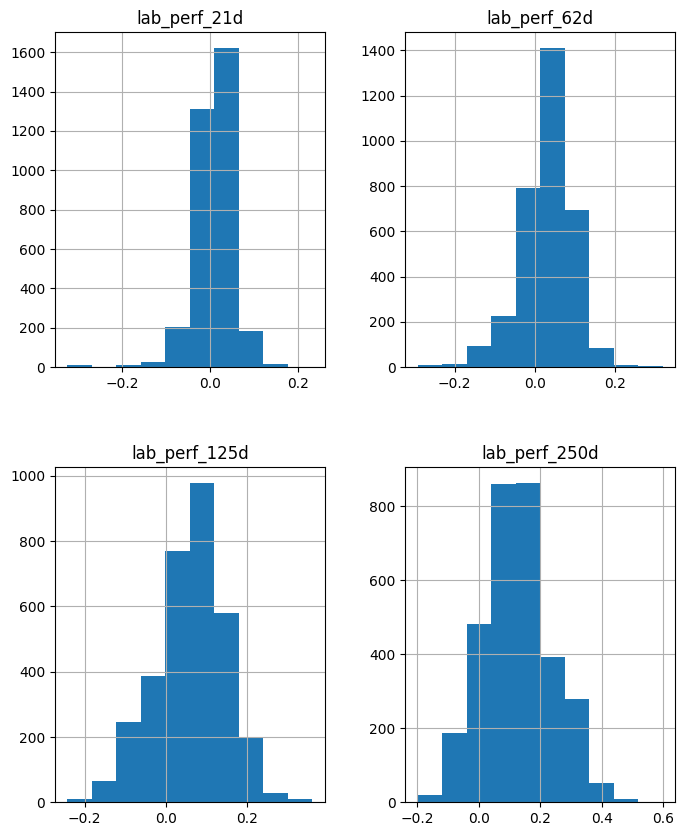

In [28]:
for lab in list_label["LABEL"].to_list():
    print(f"label : "+lab)
    print(df.loc[:,lab].dropna().iloc[[0,-1]])
(df.loc[:,list_label["LABEL"]]).hist(figsize=(8,10))
#df_selected.hist(figsize=(15,20))
df.head()

split dataframe into X,y

In [47]:
df_x_train,col_y_train=split_df_x_y(df_in=df_selected,list_features=list_feat,str_label=lab_studied,drop_na=True)
df_x_valid,col_y_valid=split_df_x_y(df_in=df_valid,list_features=list_feat,str_label=lab_studied,drop_na=True)

In [ ]:
df_x_train.describe()

Hyperparameter tuning for Random Forest with random search CV

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=50, stop=200, num=12)] # number of trees in the foreset
max_features = ['sqrt'] # max number of features considered for splitting a node
max_depth = [int(x) for x in np.linspace(2, 6, num=5)]# max number of levels in each decision tree
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)# min number of data points placed in a node before the node is split
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True) #min number of data points allowed in a leaf node

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestRegressor()

rf_fitted = randomizedsearch_cv_fit_report(estimator=rf, param_distributions=random_grid, x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=200,n_top=5)

#21 : n_estimators': 90, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 6
#62 : 'n_estimators': 172, 'min_samples_split': 0.5, 'min_samples_leaf': 0.2, 'max_features': 'sqrt', 'max_depth': 5

check parameters and test with validation dataset and show feature importance

In [ ]:
rand_frst_reg = RandomForestRegressor(n_estimators=172, bootstrap=True, criterion="squared_error",
                                          random_state=rnd_key, max_depth=5, min_samples_split=0.5, min_samples_leaf=0.2,max_features="sqrt")
rand_frst_reg.fit(df_x_train, col_y_train)


print(f"Training score : {rand_frst_reg.score(df_x_train, col_y_train)}")

y_pred_valid=rand_frst_reg.predict(df_x_valid)
print(f"Random Forest regressor score:{rand_frst_reg.score(df_x_valid,col_y_valid)}")

feat_imp=rand_frst_reg.feature_importances_
std_feat_imp = np.std([tree.feature_importances_ for tree in rand_frst_reg.estimators_], axis=0)
pd.Series(feat_imp,index=df_x_train.columns).sort_values(ascending=False)

save model

In [ ]:
ext_pkl=".pkl"
rf_suffix="_rf_reg_v1"
joblib.dump(rand_frst_reg,PATH_MODEL+symb+"_"+lab_studied+rf_suffix+ext_pkl)

Same thing with XGBoost
Hyperparameter tuning for XGBoost with random search CV

In [ ]:

# 5 min 30 s !!

random_grid = {
    "colsample_bytree": [x for x in np.linspace(0.5, 1, num=6)], # default 1 subsample ratio of columns when constructing each tree
    "gamma": [x for x in np.linspace(0, 0.1, num=3)], # default 0 minimum loss reduction to make a further patition on a leaf
    "learning_rate": [x for x in np.linspace(0.05, 0.2, num=8)], # default 0.1 
    "max_depth": [int(x) for x in np.linspace(2, 8, num=5)], # default 6 max depth of the tree
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=200, num=7)], # default 100
    "subsample": [x for x in np.linspace(0.4, 1, num=6)], # default 1 subsample ratio of the training instances
    "min_child_weight": [x for x in np.linspace(0.8, 2, num=7)] # default 1 minimum sum of instance weight needed in a child
}

xgb_reg = xgb.XGBRegressor()

xgb_fitted = randomizedsearch_cv_fit_report(estimator=xgb_reg, param_distributions=random_grid, x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=200,n_top=5)

#21 Parameters: {'subsample': 1.0, 'n_estimators': 125, 'min_child_weight': 1.0, 'max_depth': 2, 'learning_rate': 0.1142857142857143, 'gamma': 0.1, 'colsample_bytree': 0.7}
#21 {'subsample': 1.0, 'n_estimators': 75, 'min_child_weight': 1.4, 'max_depth': 6, 'learning_rate': 0.15714285714285717, 'gamma': 0.1, 'colsample_bytree': 0.6}
#62 'subsample': 1.0, 'n_estimators': 125, 'min_child_weight': 1.4, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.05, 'colsample_bytree': 1.0

In [ ]:
# avoir un gamma <=0.3 voire 0.1 et meme 0

params = {
    "learning_rate": 0.05,
    "subsample": 1.0,
    "gamma": 0.05,
    "colsample_bytree":1.0,
    "max_depth":3,
    "n_estimators":125,
    "min_child_weight":1.4
}

# params = {
#     "learning_rate": 0.11,
#     "subsample": 1.0,
#     "gamma": 0.1,
#     "colsample_bytree":0.7,
#     "max_depth":2,
#     "n_estimators":100,
#     "min_child_weight":1.0
# }
xgb_reg = xgb.XGBRegressor(random_state=int(rnd_key),
                                learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],
                                colsample_bytree=params['colsample_bytree'],max_depth=params['max_depth'],
                                n_estimators=params['n_estimators'],min_child_weight=params['min_child_weight'],verbosity=1)

#xgb_reg=xgb.XGBRegressor()
xgb_reg.fit(df_x_train, col_y_train)

print(f"Training score : {xgb_reg.score(df_x_train, col_y_train)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(f"Accuracy XGBoost regressor Validation:{xgb_reg.score(df_x_valid,col_y_valid)}")

#print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_reg) 



In [ ]:
ext_pkl=".pkl"
xgb_suffix="_xgb_reg_v1"
joblib.dump(xgb_reg,PATH_MODEL+symb+"_"+lab_studied+xgb_suffix+ext_pkl)

Same thing with Logisitc regression 
Hyperparameter tuning for Logistic Regression with random search CV

In [54]:
random_grid = {
    "solver": ["svd", "cholesky", "lsqr", "sag"] ,
    "alpha" : [x for x in  np.logspace(1e-5, 100, 20)],
    "fit_intercept" : [True,False],
    "normalize" : [True,False]
}
lin_reg = Ridge()

lin_fitted = randomizedsearch_cv_fit_report(estimator=lin_reg, param_distributions=random_grid, x_train=df_x_train, y_train=col_y_train, random_state=int(rnd_key), n_iter=200,n_top=5)

#Parameters: {'solver': 'cholesky', 'normalize': False, 'fit_intercept': True, 'alpha': 183302.06958438578}

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previo

Accuracy train (neg_mean_squared_error) :-0.0020341069380088533
Model with rank: 1
Mean validation score: -0.002106664470903896 (std: 0.0014276686623178499)
Parameters: {'solver': 'cholesky', 'normalize': False, 'fit_intercept': True, 'alpha': 183302.06958438578}

Model with rank: 2
Mean validation score: -0.0021066726977691935 (std: 0.001427693977418902)
Parameters: {'solver': 'sag', 'normalize': False, 'fit_intercept': True, 'alpha': 183302.06958438578}

Model with rank: 3
Mean validation score: -0.0021067331678604343 (std: 0.0014276112767333596)
Parameters: {'solver': 'lsqr', 'normalize': False, 'fit_intercept': True, 'alpha': 183302.06958438578}

Model with rank: 4
Mean validation score: -0.0021218846915656148 (std: 0.0014632706056786988)
Parameters: {'solver': 'lsqr', 'normalize': False, 'fit_intercept': True, 'alpha': 33598875062.323475}

Model with rank: 5
Mean validation score: -0.002121884691699376 (std: 0.0014632706055775124)
Parameters: {'solver': 'svd', 'normalize': False, 

c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
c:\Projets\MarketDataEnrichment\.env\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previo